In [5]:
# Basic setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, r2_score

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.feature_selection import f_classif
from sklearn.inspection import permutation_importance

from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Load your cleaned dataset
df = pd.read_csv("C:/Users/VIGNEESH GPL/BigData/data2/encoded_dataset.csv")
df.head()

,studyhours,attendance,resources,extracurricular,motivation,internet,gender,age,learningstyle,onlinecourses,discussions,assignmentcompletion,edutech,stresslevel,finalgrade
0,19,64,0,0,0,1,1,19,0,8,1,59,0,1,3
1,19,64,0,0,0,1,1,23,1,16,0,90,0,1,2
2,19,64,0,0,0,1,1,28,2,19,0,67,1,1,0
3,19,64,0,1,0,1,1,19,0,8,1,59,0,1,3
4,19,64,0,1,0,1,1,23,1,16,0,90,0,1,2


Dataset shape: (11790, 15)
['studyhours', 'attendance', 'resources', 'extracurricular', 'motivation', 'internet', 'gender', 'age', 'learningstyle', 'onlinecourses', 'discussions', 'assignmentcompletion', 'edutech', 'stresslevel', 'finalgrade']
Number of predictors: 14

Top features by p-value (smallest p = more evidence of difference across classes):
             feature   F_stat  p_value
         discussions 8.945959 0.000006
         stresslevel 5.484934 0.000921
assignmentcompletion 4.025487 0.007149
             edutech 2.336753 0.071642
       learningstyle 2.238500 0.081614
          attendance 2.102330 0.097669
              gender 1.642173 0.177335
       onlinecourses 1.639196 0.178010
          motivation 1.501477 0.211970
     extracurricular 1.482797 0.217014
            internet 1.399860 0.240775
           resources 1.216649 0.301892
                 age 0.993002 0.394922
          studyhours 0.192330 0.901676

Number of low-confidence predictions (max_prob < 0.5): 663 / 

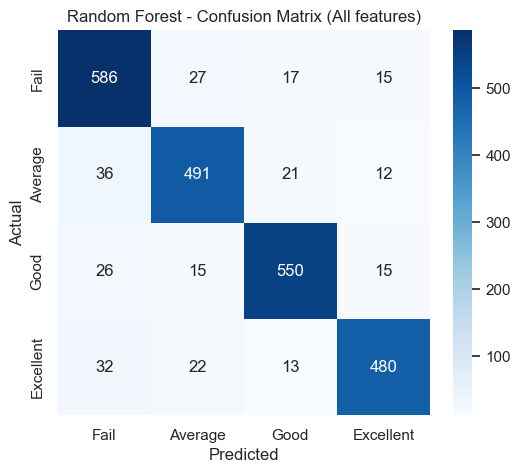

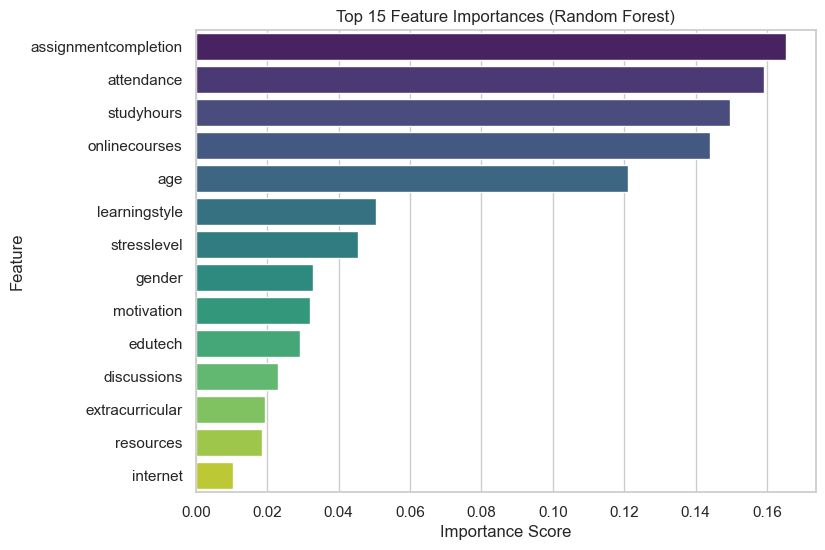


Top features by permutation importance:
             feature  perm_mean  perm_std
          attendance   0.193511  0.008481
assignmentcompletion   0.169063  0.006510
       onlinecourses   0.164207  0.006257
                 age   0.126802  0.005485
          studyhours   0.119953  0.005392
         stresslevel   0.105259  0.004983
         discussions   0.085899  0.004078
       learningstyle   0.066179  0.004369
              gender   0.046628  0.004402
             edutech   0.037638  0.002353
     extracurricular   0.002311  0.002344
           resources   0.001569  0.001414
            internet   0.001315  0.001047
          motivation  -0.001993  0.001638

Summary (importance + p-value):
                      rf_importance  perm_mean   p_value
feature                                                 
assignmentcompletion       0.165400   0.169063  0.007149
attendance                 0.159203   0.193511  0.097669
studyhours                 0.149545   0.119953  0.901676
onlinecours

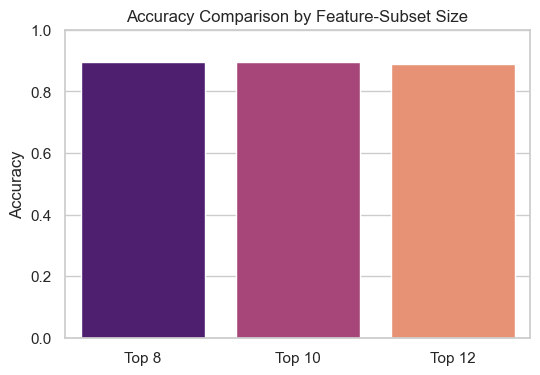

In [8]:
# Random Forest

sns.set(style="whitegrid")

# --------------------------
# 1. Load dataset (encoded)
# --------------------------
print("Dataset shape:", df.shape)
print(df.columns.tolist())

# List of predictor columns (exclude finalgrade)
predictors = [c for c in df.columns if c != "finalgrade"]
print("Number of predictors:", len(predictors))

# X and y
X = df[predictors]
y = df["finalgrade"]

# --------------------------
# 2. Train/test split + scaling
# --------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --------------------------
# 3. Compute p-values (ANOVA f_classif)
# --------------------------
F, pvals = f_classif(X_train_scaled, y_train)
pvalues_df = pd.DataFrame({
    "feature": predictors,
    "F_stat": F,
    "p_value": pvals
}).sort_values("p_value")
print("\nTop features by p-value (smallest p = more evidence of difference across classes):")
print(pvalues_df.head(15).to_string(index=False))

# --------------------------
# 4. Train baseline Random Forest on ALL predictors
# --------------------------
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train_scaled, y_train)

# Standard prediction (argmax of predicted probabilities)
probs = rf.predict_proba(X_test_scaled)
y_pred_argmax = probs.argmax(axis=1)

# Apply threshold logic: flag low confidence where max probability < 0.5
max_probs = probs.max(axis=1)
low_confidence_idx = np.where(max_probs < 0.5)[0]
print(f"\nNumber of low-confidence predictions (max_prob < 0.5): {len(low_confidence_idx)} / {len(y_test)}")

# Evaluation
print("\n=== Baseline Random Forest (ALL features) ===")
print("Accuracy:", round(accuracy_score(y_test, y_pred_argmax), 3))
print("\nClassification Report:\n", classification_report(y_test, y_pred_argmax, zero_division=1))

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred_argmax)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Fail","Average","Good","Excellent"],
            yticklabels=["Fail","Average","Good","Excellent"])
plt.title("Random Forest - Confusion Matrix (All features)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# --------------------------
# 5. Feature importance (from RF) and permutation importance
# --------------------------
feat_imp = pd.Series(rf.feature_importances_, index=predictors).sort_values(ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(
    x=feat_imp.head(15).values,
    y=feat_imp.head(15).index,
    hue=feat_imp.head(15).index,   
    palette="viridis",
    legend=False               
)
plt.title("Top 15 Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

# Permutation importance
perm = permutation_importance(rf, X_test_scaled, y_test, n_repeats=20, random_state=42, n_jobs=-1)
perm_df = pd.DataFrame({
    "feature": predictors,
    "perm_mean": perm.importances_mean,
    "perm_std": perm.importances_std
}).sort_values("perm_mean", ascending=False)
print("\nTop features by permutation importance:")
print(perm_df.head(15).to_string(index=False))

# Combine importance + p-values
summary = pd.DataFrame({
    "feature": predictors,
    "rf_importance": feat_imp.reindex(predictors).values,
    "perm_mean": perm_df.set_index("feature")["perm_mean"].reindex(predictors).values,
    "p_value": pvalues_df.set_index("feature")["p_value"].reindex(predictors).values
}).set_index("feature").sort_values("rf_importance", ascending=False)
print("\nSummary (importance + p-value):")
print(summary.head(15).to_string())

# --------------------------
# 6. Compare models using Top 8, Top 10, Top 12 features
# --------------------------
def evaluate_top_n(n):
    top_feats = feat_imp.head(n).index.tolist()
    Xtr = X_train[top_feats]
    Xte = X_test[top_feats]
    scaler_local = StandardScaler()
    Xtr_s = scaler_local.fit_transform(Xtr)
    Xte_s = scaler_local.transform(Xte)
    rf_local = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
    rf_local.fit(Xtr_s, y_train)
    y_pred = rf_local.predict(Xte_s)
    acc = accuracy_score(y_test, y_pred)
    print(f"\nTop {n} features: {top_feats}")
    print(f"Accuracy (Top {n}): {acc:.4f}")
    print(classification_report(y_test, y_pred, zero_division=1))
    return acc

acc8  = evaluate_top_n(8)
acc10 = evaluate_top_n(10)
acc12 = evaluate_top_n(12)

# Plot accuracy comparison
plt.figure(figsize=(6,4))
sns.barplot(
    x=["Top 8", "Top 10", "Top 12"],
    y=[acc8, acc10, acc12],
    hue=["Top 8", "Top 10", "Top 12"],
    palette="magma",
    legend=False
)

plt.ylim(0,1)
plt.title("Accuracy Comparison by Feature-Subset Size")
plt.ylabel("Accuracy")
plt.show()



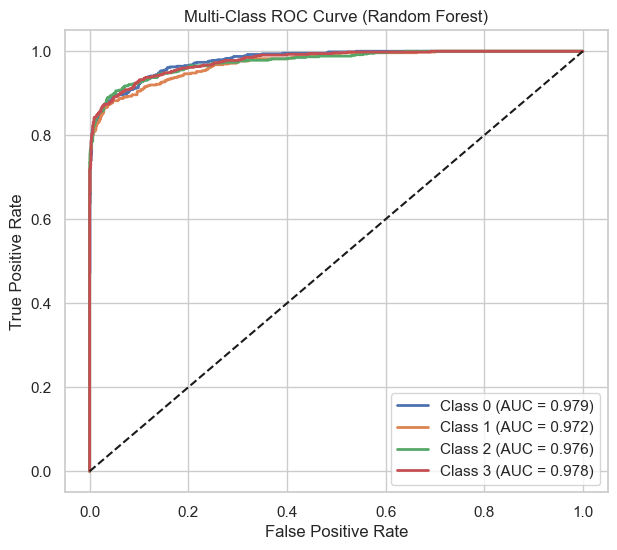

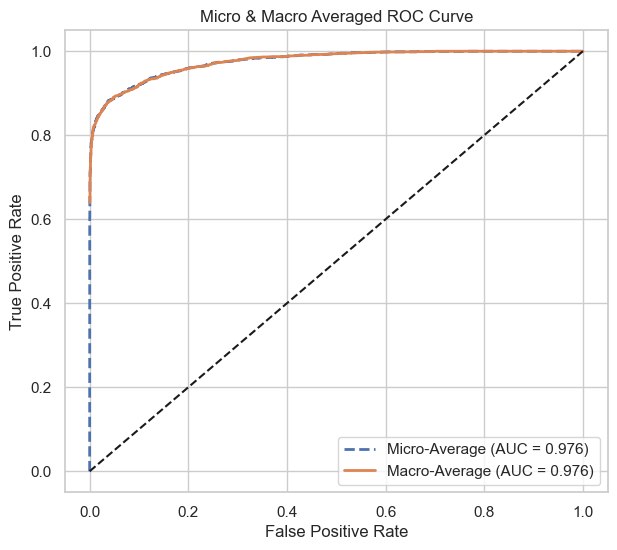


=== AUC Score Summary ===
Class 0 AUC: 0.979
Class 1 AUC: 0.972
Class 2 AUC: 0.976
Class 3 AUC: 0.978

Micro-Averaged AUC: 0.976
Macro-Averaged AUC: 0.976



In [7]:
# Multi-Class ROC Curve + Micro/Macro AUC (Random Forest)
# --------------------------
# 7. ROC Curve
# --------------------------

X = df.drop("finalgrade", axis=1)
y = df["finalgrade"]

classes = sorted(y.unique())

# Train-Test Split & Scaling
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Train One-vs-Rest Random Forest
rf_ovr = OneVsRestClassifier(
    RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
)
rf_ovr.fit(X_train_scaled, y_train)

# Predicted probabilities for ROC
y_score = rf_ovr.predict_proba(X_test_scaled)

# Binarize labels (required for multi-class ROC)
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_test_bin.shape[1]

# ------------------------------------
# 1. Plot ROC for Each Class
# ------------------------------------

plt.figure(figsize=(7,6))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Class {classes[i]} (AUC = {roc_auc:.3f})")

# Diagonal reference line
plt.plot([0,1], [0,1], "k--")

plt.title("Multi-Class ROC Curve (Random Forest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# ------------------------------------
# 2. Micro & Macro Averaged ROC
# ------------------------------------
# Micro-average
fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
auc_micro = auc(fpr_micro, tpr_micro)

# Macro-average
auc_macro = roc_auc_score(y_test_bin, y_score, average="macro")

plt.figure(figsize=(7,6))
plt.plot(fpr_micro, tpr_micro, linestyle="--", linewidth=2,
         label=f"Micro-Average (AUC = {auc_micro:.3f})")

# Create macro curve
mean_tpr = np.zeros_like(fpr_micro)
for i in range(n_classes):
    fpr_i, tpr_i, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    mean_tpr += np.interp(fpr_micro, fpr_i, tpr_i)
mean_tpr /= n_classes

plt.plot(fpr_micro, mean_tpr, linewidth=2,
         label=f"Macro-Average (AUC = {auc_macro:.3f})")

plt.plot([0,1], [0,1], "k--")
plt.title("Micro & Macro Averaged ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# ------------------------------------
# 3. AUC Score Summary Table
# ------------------------------------
print("\n=== AUC Score Summary ===")
for i in range(n_classes):
    class_auc = roc_auc_score(y_test_bin[:, i], y_score[:, i])
    print(f"Class {classes[i]} AUC: {class_auc:.3f}")

print(f"\nMicro-Averaged AUC: {auc_micro:.3f}")
print(f"Macro-Averaged AUC: {auc_macro:.3f}\n")


In [1]:
import joblib

